<font color = blue><font size = 6> 실험설명 </font></font><br>
이미 이전에 1step에서 RNN기반이 1step의 예측에 대해서 좋지 않다는 것을 몸소 경험했다 하지만 Online-learning에서는 좀 다른 결과가 나올까 기대감에 진행해 보았다<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [43]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [44]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [45]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':8,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/online_learning_seq2seq']

In [46]:
class Encoder(nn.Module):
    def __init__(self,configs):
        super(Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [47]:
class Decoder(nn.Module):
    def __init__(self,configs):
        super(Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        output = self.linear(lstm_out)
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [48]:
tup= (1,2)
len(tup)

2

In [49]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.encoder = Encoder(configs)
        self.decoder = Decoder(configs)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        _,final_hidden = self.encoder(x)
        output,_ = self.decoder(x = x[:,-1,:].view(-1,1,1),encoder_hidden = final_hidden)
        
        return output

In [50]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [51]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [52]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [53]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [54]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
        
        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 137.5016677031043 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 76.39105237715425 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 41.41689789225483 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 16.42601023553408 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 1.4107021766650758 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 0.8702019664539944 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 0.8709468811100938 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 0.870286379457446 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 0.8690391971688168 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 0.867460156460388 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 0.8660137309040602 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 0.8643597428488127 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 0.8631337324514092 %
Adjus

In [55]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.39387777075171476 %
SMAPE 0.3403413949999958 %
SMAPE 0.2713759569451213 %
SMAPE 0.2513744402676821 %
SMAPE 0.1843511804472655 %
SMAPE 0.1857341929571703 %
SMAPE 0.13916797505225986 %
SMAPE 0.12341341003775595 %
SMAPE 0.07737810991238803 %
SMAPE 0.0558278966054786 %
SMAPE 0.06652593519538641 %
SMAPE 0.09278762276517227 %
SMAPE 0.054903187905438244 %
SMAPE 0.006329864196999324 %
SMAPE 0.02123540506727295 %
SMAPE 0.05312015424715355 %
SMAPE 0.005585618048868923 %
SMAPE 0.030382078941329386 %
SMAPE 0.006143208729639582 %
SMAPE 0.00483793239499164 %
SMAPE 0.026803268512594514 %
SMAPE 0.02764067237148993 %
SMAPE 0.07439083501230925 %
SMAPE 0.03233628722955473 %
SMAPE 0.03058994670573156 %
SMAPE 0.033172051087603904 %
SMAPE 0.007508343112277771 %
SMAPE 0.043208823684835806 %
SMAPE 0.03987780539318919 %
SMAPE 0.03560200514039025 %
SMAPE 0.01984407628333429 %
SMAPE 0.008804161131024557 %
SMAPE 0.00325285100110051 %
SMAPE 0.00043248436175247207 %
SMAPE 0.021454494875797536 %
SMAPE 0.0151

SMAPE 0.006247102012935102 %
SMAPE 0.1531464671716094 %
SMAPE 0.0015678575784221493 %
SMAPE 0.10302376659819855 %
SMAPE 0.04337626794585958 %
SMAPE 0.05867141092312522 %
SMAPE 0.08056423621019349 %
SMAPE 0.08505450654774904 %
SMAPE 0.09806075389496981 %
SMAPE 0.032217666725046 %
SMAPE 0.023677262135606725 %
SMAPE 0.022284226506599225 %
SMAPE 0.01558350665436592 %
SMAPE 0.02679738558799727 %
SMAPE 0.0002166547721529355 %
SMAPE 0.002190404713722671 %
SMAPE 0.0012200560955903939 %
SMAPE 0.006037473361317325 %
SMAPE 0.0018807645459020252 %
SMAPE 0.006894587468863733 %
SMAPE 0.008823616219132191 %
SMAPE 0.0021025576137674307 %
SMAPE 0.025074621407839004 %
SMAPE 0.0021255053896567233 %
SMAPE 0.04935123960603959 %
SMAPE 0.012230740148709176 %
SMAPE 0.017218651773873717 %
SMAPE 0.02968619077000767 %
SMAPE 0.004799616790528205 %
SMAPE 0.014282392024199451 %
SMAPE 0.012166111750275377 %
SMAPE 0.1006513857282698 %
SMAPE 0.011200766198840029 %
SMAPE 0.05220638992614112 %
SMAPE 0.024974643645691685

SMAPE 0.048514905385673046 %
SMAPE 0.021998135656758677 %
SMAPE 0.07558900449657813 %
SMAPE 0.03474653470038902 %
SMAPE 0.0030624584093956746 %
SMAPE 0.05867800849955529 %
SMAPE 0.012470974468669738 %
SMAPE 0.11661932826973498 %
SMAPE 0.01696283266937826 %
SMAPE 0.03826048981864005 %
SMAPE 0.003931963637199942 %
SMAPE 0.005325602132352003 %
SMAPE 0.052760988764930516 %
SMAPE 0.018950335434055887 %
SMAPE 0.0017753279920498244 %
SMAPE 0.008588338808806384 %
SMAPE 0.0014622572442632986 %
SMAPE 0.02028025702747982 %
SMAPE 0.039012557826936245 %
SMAPE 0.002093783953704076 %
SMAPE 0.011192174253210396 %
SMAPE 0.0020849399047477846 %
SMAPE 0.0046615504230089755 %
SMAPE 0.08053968369495124 %
SMAPE 0.06855948822339997 %
SMAPE 0.029780286189634353 %
SMAPE 0.0004958323594053127 %
SMAPE 0.04031837059301324 %
SMAPE 0.1021436417941004 %
SMAPE 0.13059966987930238 %
SMAPE 0.07279271254083142 %
SMAPE 0.03806273208465427 %
SMAPE 0.09857695264508949 %
SMAPE 0.08974556170869619 %
SMAPE 0.10350290819769725

SMAPE 0.013853125095920404 %
SMAPE 0.04415685703861527 %
SMAPE 0.008053817574719346 %
SMAPE 0.028908362364745702 %
SMAPE 0.0011974718233176418 %
SMAPE 6.196804001490364e-05 %
SMAPE 0.06064426881494001 %
SMAPE 0.015952305737300776 %
SMAPE 0.03610050069983117 %
SMAPE 0.0012019782694494552 %
SMAPE 0.0017974913797615957 %
SMAPE 0.029535361085436307 %
SMAPE 0.02529939940723125 %
SMAPE 0.0025520870888726677 %
SMAPE 0.05225876497570426 %
SMAPE 0.00383056943212523 %
SMAPE 0.005144376857259658 %
SMAPE 0.004938931839333804 %
SMAPE 0.00020237904652731234 %
SMAPE 0.015525310460361652 %
SMAPE 0.019897794460121077 %
SMAPE 0.04601726940018125 %
SMAPE 0.04826460740878247 %
SMAPE 0.004388155639858837 %
SMAPE 0.010797632296998927 %
SMAPE 0.029472736016032286 %
SMAPE 0.030020743783097714 %
SMAPE 0.059783516218885786 %
SMAPE 0.03646897684666328 %
SMAPE 0.0031462422341235197 %
SMAPE 0.03662109552533366 %
SMAPE 0.03064339590491727 %
SMAPE 0.04138395490008406 %
SMAPE 0.032984033940010704 %
SMAPE 0.0062522914

SMAPE 0.07408329640747979 %
SMAPE 0.033704091285471804 %
SMAPE 0.022358077025273815 %
SMAPE 0.0036440041080538776 %
SMAPE 0.04522119136527181 %
SMAPE 0.004003718767719988 %
SMAPE 0.000886367976818292 %
SMAPE 0.05332371874828823 %
SMAPE 0.0030781110868218775 %
SMAPE 8.656135243256813e-05 %
SMAPE 0.005468690968257306 %
SMAPE 0.0012040402239392733 %
SMAPE 0.0028087349379219972 %
SMAPE 0.03481412796827499 %
SMAPE 0.007241366005104056 %
SMAPE 0.04465157832601108 %
SMAPE 0.01753219068632461 %
SMAPE 0.012878066872133333 %
SMAPE 0.017524656766909175 %
SMAPE 0.018796090793330222 %
SMAPE 0.012131764682692392 %
SMAPE 0.0008291628901488934 %
SMAPE 0.024131787686201278 %
SMAPE 0.024628857710922603 %
SMAPE 0.0021956390018971206 %
SMAPE 0.05160387058276684 %
SMAPE 0.00047740357562986446 %
SMAPE 0.006804298165803857 %
SMAPE 0.04102751665050164 %
SMAPE 0.048830540355993435 %
SMAPE 0.015380861987068783 %
SMAPE 0.03908186752232723 %
SMAPE 0.001089126371411453 %
SMAPE 0.056747765338514 %
SMAPE 0.003613342

SMAPE 0.030388032117571125 %
SMAPE 0.000916022770674374 %
SMAPE 0.03526800023496435 %
SMAPE 0.06008734076749533 %
SMAPE 0.007685931193435636 %
SMAPE 0.022439306544072224 %
SMAPE 0.0018476633802961828 %
SMAPE 0.0008029092347356936 %
SMAPE 0.0003578608826302343 %
SMAPE 0.0027321029241420547 %
SMAPE 0.0017187405988607905 %
SMAPE 0.002258059892277231 %
SMAPE 0.005613912618457562 %
SMAPE 0.0014422619851188756 %
SMAPE 0.03217002736732866 %
SMAPE 0.028021605319736406 %
SMAPE 0.00618931957866664 %
SMAPE 0.0002931105307055759 %
SMAPE 0.0426718314865866 %
SMAPE 0.028532793854310515 %
SMAPE 0.004839675386577369 %
SMAPE 0.004701545004465402 %
SMAPE 0.0032764410200556426 %
SMAPE 0.01111426565039153 %
SMAPE 0.007308729095512944 %
SMAPE 0.0028204959716049416 %
SMAPE 0.0022460804779882437 %
SMAPE 0.013096320335705512 %
SMAPE 0.025737989871061018 %
SMAPE 0.0016446948953685592 %
SMAPE 0.008760520802042038 %
SMAPE 0.01737389554358515 %
SMAPE 0.015611449744369567 %
SMAPE 0.03623362477799219 %
SMAPE 0.0034

SMAPE 0.0007646514753787413 %
SMAPE 0.006320850140319578 %
SMAPE 0.005562487757813983 %
SMAPE 0.0013079519473180312 %
SMAPE 0.004523883352405278 %
SMAPE 0.006859651701788039 %
SMAPE 0.0005171567611768069 %
SMAPE 0.016195728046056956 %
SMAPE 0.021265791821804214 %
SMAPE 0.0011082500535479767 %
SMAPE 0.012484062541545882 %
SMAPE 0.007648038036023763 %
SMAPE 0.00016493651651217078 %
SMAPE 0.00990494883861004 %
SMAPE 0.004174084180419868 %
SMAPE 0.001622156968693389 %
SMAPE 0.001144406942003684 %
SMAPE 0.015471057792694863 %
SMAPE 0.011166216532643602 %
SMAPE 0.002033557718824852 %
SMAPE 0.004742807531826543 %
SMAPE 0.00977150577065089 %
SMAPE 0.011599630757856971 %
SMAPE 0.006385891745090077 %
SMAPE 0.001586831849600401 %
SMAPE 0.02359685839985559 %
SMAPE 0.014896871469119333 %
SMAPE 0.022089116977952017 %
SMAPE 0.0034776744737143868 %
SMAPE 0.001510617632135336 %
SMAPE 0.0036824063432234766 %
SMAPE 0.013047409033816848 %
SMAPE 0.0104251095654746 %
SMAPE 0.044585127389837 %
SMAPE 0.006483

SMAPE 0.018748802751304083 %
SMAPE 0.0013068324888365623 %
SMAPE 0.00607219655611857 %
SMAPE 0.008288827665467124 %
SMAPE 0.002838184775235675 %
SMAPE 0.01271367814904778 %
SMAPE 0.005239261060637546 %
SMAPE 0.0008036075670361242 %
SMAPE 0.016789927271759097 %
SMAPE 0.006929070337292842 %
SMAPE 0.04397916490052012 %
SMAPE 0.06945494760293514 %
SMAPE 0.012741310978128695 %
SMAPE 0.0013202369336298148 %
SMAPE 0.010778027417615021 %
SMAPE 0.004761381251157104 %
SMAPE 0.014442272854296336 %
SMAPE 0.00020335864992659936 %
SMAPE 0.000638318350723921 %
SMAPE 0.0037399563201816473 %
SMAPE 0.0008069307672187165 %
SMAPE 0.0036991993810531194 %
SMAPE 0.005454702166048264 %
SMAPE 0.010685588925511524 %
SMAPE 0.00044361356503941357 %
SMAPE 0.006605220829655423 %
SMAPE 0.005483704223046004 %
SMAPE 0.0008927827607720928 %
SMAPE 0.012879950034253795 %
SMAPE 0.00018439309123152725 %
SMAPE 0.012983526125935894 %
SMAPE 0.0038962860858049453 %
SMAPE 0.02620491957775783 %
SMAPE 0.00030338633963822303 %
SMA

SMAPE 0.000381293187075471 %
SMAPE 0.008935411416771899 %
SMAPE 0.002260480138922105 %
SMAPE 0.005565195105809551 %
SMAPE 0.02911272694473155 %
SMAPE 0.0007985491250863674 %
SMAPE 0.0015610760497253293 %
SMAPE 0.01426308074150029 %
SMAPE 0.03923278041474987 %
SMAPE 0.004218930939458687 %
SMAPE 0.03236896153248381 %
SMAPE 0.02380408881049334 %
SMAPE 0.0053131233451182425 %
SMAPE 0.018809499821600184 %
SMAPE 0.002202510815394021 %
SMAPE 0.0014452142021497139 %
SMAPE 0.0035399941844218574 %
SMAPE 0.01445490587155973 %
SMAPE 0.005346616077844146 %
SMAPE 0.02647101680850028 %
SMAPE 0.00031560231370519887 %
SMAPE 0.00535643350377768 %
SMAPE 0.02427554625501216 %
SMAPE 0.06261238758452237 %
SMAPE 0.00046414657208515564 %
SMAPE 0.0012864351067563007 %
SMAPE 0.0023226920886258995 %
SMAPE 0.0010108245183317877 %
SMAPE 0.01574023791926038 %
SMAPE 0.003066392205255397 %
SMAPE 0.03226576829183614 %
SMAPE 0.06875794578809291 %
SMAPE 0.0118761526352813 %
SMAPE 0.02774980090907775 %
SMAPE 0.0044037682

SMAPE 0.014356987766888095 %
SMAPE 0.02313125771865998 %
SMAPE 0.0022655997236142866 %
SMAPE 0.004287171458827288 %
SMAPE 0.0012006234242818437 %
SMAPE 0.008637844669763695 %
SMAPE 0.015032206378293722 %
SMAPE 0.008376180079288531 %
SMAPE 0.0004699126530880448 %
SMAPE 0.0101019547659007 %
SMAPE 0.0035686380338972863 %
SMAPE 0.0015413240000867745 %
SMAPE 0.025930195489252125 %
SMAPE 0.039306186936300946 %
SMAPE 0.009428855000351177 %
SMAPE 0.04202225284097949 %
SMAPE 0.0024905947357396485 %
SMAPE 0.0065217466220275355 %
SMAPE 0.01706325947498044 %
SMAPE 0.03894620228311396 %
SMAPE 0.044075399317080155 %
SMAPE 0.0006015778324268695 %
SMAPE 0.0007031329840501144 %
SMAPE 0.002018426221255254 %
SMAPE 0.01119111407120954 %
SMAPE 0.0005633676037319901 %
SMAPE 6.682935391921774e-05 %
SMAPE 0.0031662188762666688 %
SMAPE 0.006154265566763683 %
SMAPE 0.002195426465398498 %
SMAPE 0.0007304834446273389 %
SMAPE 0.02788206491686651 %
SMAPE 0.004954659618050528 %
SMAPE 0.023775867390554595 %
SMAPE 0.0

SMAPE 0.00156453020571945 %
SMAPE 0.0001521224235929708 %
SMAPE 0.0024431956505992503 %
SMAPE 0.018694001208388045 %
SMAPE 0.006029210995372125 %
SMAPE 8.832936644554138 %
SMAPE 17.949719458818436 %
SMAPE 25.822678178548813 %
SMAPE 9.608451277017593 %
SMAPE 8.263540461659431 %
SMAPE 7.56732901930809 %
SMAPE 2.1285325549542904 %
SMAPE 0.42041843174956733 %
SMAPE 0.41801593941636384 %
SMAPE 0.42441131779924035 %
SMAPE 0.3543096208013594 %
SMAPE 0.28061555582098663 %
SMAPE 0.23365813109558076 %
SMAPE 0.07635244724224322 %
SMAPE 0.0035292744850181634 %
SMAPE 0.005807481989137386 %
SMAPE 0.030763774599080307 %
SMAPE 0.0005200950889303613 %
SMAPE 0.0034311348769193724 %
SMAPE 0.00134304729493806 %
SMAPE 0.017966265561007333 %
SMAPE 0.030122510067712934 %
SMAPE 0.0006494862092267795 %
SMAPE 0.007934448401130112 %
SMAPE 0.008038680422146172 %
SMAPE 0.0022359443383095368 %
SMAPE 0.00293022027570089 %
SMAPE 0.010118028526107992 %
SMAPE 0.029137653443115138 %
SMAPE 0.004913453893934161 %
SMAPE 0.

SMAPE 0.010951210819747814 %
SMAPE 0.005864207708242475 %
SMAPE 0.0036567732412535747 %
SMAPE 0.0008784107595545265 %
SMAPE 0.03253394558313971 %
SMAPE 0.002551769104357504 %
SMAPE 0.02850163125299332 %
SMAPE 0.0006275804940969465 %
SMAPE 0.004051030466584393 %
SMAPE 0.002958734065259705 %
SMAPE 0.004247081342455772 %
SMAPE 0.0068867173043614125 %
SMAPE 0.0004208896211252977 %
SMAPE 0.0002128515479427051 %
SMAPE 0.004237716756307464 %
SMAPE 0.005420203521715905 %
SMAPE 0.0005132971860746238 %
SMAPE 0.0030194800937763944 %
SMAPE 0.0002028433210341518 %
SMAPE 0.02075346974585557 %
SMAPE 0.0007562985606739403 %
SMAPE 0.01072466691482532 %
SMAPE 0.02176632668044931 %
SMAPE 0.009116746974171974 %
SMAPE 0.0014453947855770366 %
SMAPE 0.013953505471391736 %
SMAPE 0.0013240648898360519 %
SMAPE 0.007530663323763065 %
SMAPE 0.0004202433639761694 %
SMAPE 0.022693835993635503 %
SMAPE 0.010120195437593793 %
SMAPE 0.0018286081642600036 %
SMAPE 0.0032764460378444933 %
SMAPE 0.01624996517894317 %
SMAPE

SMAPE 0.007569658864987616 %
SMAPE 0.014121199996054658 %
SMAPE 0.0282864774797531 %
SMAPE 0.001137117474996785 %
SMAPE 0.0164159197500382 %
SMAPE 0.014540339697703075 %
SMAPE 0.005635604938817096 %
SMAPE 0.03675444056443666 %
SMAPE 0.004121296054876211 %
SMAPE 0.0010563143190083224 %
SMAPE 0.029544756013166307 %
SMAPE 0.05149980716669234 %
SMAPE 0.046151398313668324 %
SMAPE 0.01008484082771588 %
SMAPE 0.006359423329968195 %
SMAPE 0.019508208619527068 %
SMAPE 0.00375050926595577 %
SMAPE 0.024019055738335737 %
SMAPE 0.0035558321889936906 %
SMAPE 0.12986868555890396 %
SMAPE 0.002188800872126251 %
SMAPE 0.0001069002592828383 %
SMAPE 0.00016051904944447415 %
SMAPE 0.123431037645787 %
SMAPE 0.041425398654610035 %
SMAPE 0.054169719878700555 %
SMAPE 0.0058746083645289104 %
SMAPE 0.006778160092714813 %
SMAPE 0.011386086741083545 %
SMAPE 0.0011572747772063963 %
SMAPE 0.002662854500499634 %
SMAPE 0.0669465213723015 %
SMAPE 0.07479300949489698 %
SMAPE 0.033328977065366416 %
SMAPE 0.00260306320393

SMAPE 0.028862414212198928 %
SMAPE 0.0018060791920362362 %
SMAPE 0.03812297887634486 %
SMAPE 0.009228940628204896 %
SMAPE 0.05180215495056473 %
SMAPE 0.011222799103052239 %
SMAPE 0.004662529964377882 %
SMAPE 0.024126819043885916 %
SMAPE 0.03996136403293349 %
SMAPE 0.0006124415837973629 %
SMAPE 0.022522366816701833 %
SMAPE 0.0001340361912411936 %
SMAPE 0.03371920149947982 %
SMAPE 0.0660285348421894 %
SMAPE 0.007924309699888 %
SMAPE 0.022273437440162525 %
SMAPE 0.02663933977601118 %
SMAPE 0.05045151759986766 %
SMAPE 0.010238524839166985 %
SMAPE 0.008088329010014661 %
SMAPE 0.0053723448262488205 %
SMAPE 0.027707220098818656 %
SMAPE 0.004690219784379224 %
SMAPE 0.029544046439696103 %
SMAPE 0.030792302277404815 %
SMAPE 0.06808553670998663 %
SMAPE 0.037342996103689075 %
SMAPE 0.09454192448174581 %
SMAPE 0.0612158578587696 %
SMAPE 0.027258190501015633 %
SMAPE 0.0007891385893898927 %
SMAPE 0.010175661143875914 %
SMAPE 0.029806802500388585 %
SMAPE 0.00012147965165354435 %
SMAPE 0.01230275978741

SMAPE 0.05335726391058415 %
SMAPE 0.004675436320155768 %
SMAPE 0.0026331948910609526 %
SMAPE 0.04788657755125314 %
SMAPE 0.009923005456187184 %
SMAPE 0.004641582775803954 %
SMAPE 0.05134710035054013 %
SMAPE 0.005912155916391271 %
SMAPE 0.014418032650006296 %
SMAPE 0.00182602922034647 %
SMAPE 0.008402753457936285 %
SMAPE 0.00037811096753159745 %
SMAPE 0.02576831338228658 %
SMAPE 0.021986440840919386 %
SMAPE 0.026153191860430528 %
SMAPE 0.0004753796127516807 %
SMAPE 0.000159795553528852 %
SMAPE 0.039673505394603126 %
SMAPE 0.022472465801911312 %
SMAPE 0.0008058552586049927 %
SMAPE 0.04968071842449717 %
SMAPE 0.010057726035626047 %
SMAPE 0.032832868411787786 %
SMAPE 0.06575827740016393 %
SMAPE 0.005819757145211213 %
SMAPE 0.07346503250300884 %
SMAPE 0.022078741563746007 %
SMAPE 0.008655157718436612 %
SMAPE 0.0012397938702903843 %
SMAPE 0.003704247063176069 %
SMAPE 0.00026278799357726257 %
SMAPE 0.014157476784987466 %
SMAPE 0.02220635167407181 %
SMAPE 0.014917212420925807 %
SMAPE 0.0088255

SMAPE 0.0661210047401255 %
SMAPE 0.008586021556084233 %
SMAPE 0.0006899882665436508 %
SMAPE 0.016801073830606583 %
SMAPE 0.009385382757812977 %
SMAPE 0.005098022673195146 %
SMAPE 0.001222749625412689 %
SMAPE 0.025970284437619284 %
SMAPE 0.01612680876542072 %
SMAPE 0.004425243348322283 %
SMAPE 0.0014018022441533162 %
SMAPE 0.02010045340013278 %
SMAPE 0.006716933634535849 %
SMAPE 0.0009622583731854207 %
SMAPE 0.008707945741889489 %
SMAPE 0.005874033159926739 %
SMAPE 0.024716873961089902 %
SMAPE 0.00327706354954671 %
SMAPE 0.00013887910888144006 %
SMAPE 0.01898774862846153 %
SMAPE 0.013425267760212023 %
SMAPE 0.0007100328894793506 %
SMAPE 0.00018009025575338455 %
SMAPE 0.00226147315473213 %
SMAPE 0.006123733478055726 %
SMAPE 0.00016338586884501183 %
SMAPE 0.012634598083423045 %
SMAPE 0.00963760645822731 %
SMAPE 0.0007664066074113406 %
SMAPE 0.0024182360682658555 %
SMAPE 0.007084858967843388 %
SMAPE 0.008212180462606966 %
SMAPE 0.00712178125749574 %
SMAPE 0.001961053496543741 %
SMAPE 0.005

SMAPE 0.0001051756182164354 %
SMAPE 0.0007374702935578625 %
SMAPE 0.0020342454652109154 %
SMAPE 0.002585715070239303 %
SMAPE 0.004896139760731444 %
SMAPE 0.011149477461394497 %
SMAPE 0.0004107248318661049 %
SMAPE 0.003173937889023648 %
SMAPE 0.01514749332849874 %
SMAPE 0.0015967144536830349 %
SMAPE 0.1992473409045488 %
SMAPE 0.10098329012544127 %
SMAPE 0.0046765903604892856 %
SMAPE 0.019059078669215523 %
SMAPE 0.05292334039148727 %
SMAPE 0.019540817909316388 %
SMAPE 0.0033389693850409685 %
SMAPE 0.00011959427020258317 %
SMAPE 1.189860506914556 %
SMAPE 1.7356661763042212 %
SMAPE 1.8837476819753647 %
SMAPE 2.1356138233095407 %
SMAPE 1.839425342157483 %
SMAPE 1.6510824486613274 %
SMAPE 1.5919061200693247 %
SMAPE 1.4745846092700958 %
SMAPE 1.4597606314346194 %
SMAPE 1.3908937806263566 %
SMAPE 1.2814684752374887 %
SMAPE 1.2177574150264263 %
SMAPE 1.0938213057816029 %
SMAPE 0.9524074299260974 %
SMAPE 0.649756281170994 %
SMAPE 0.524396987631917 %
SMAPE 1.2787119075655937 %
SMAPE 1.34294159151

SMAPE 0.0016206195346626373 %
SMAPE 0.022834461176138632 %
SMAPE 0.03790850227503029 %
SMAPE 0.0025115496089824774 %
SMAPE 0.0009301395464902384 %
SMAPE 0.08491917487737055 %
SMAPE 0.003850488587815448 %
SMAPE 0.03673785621191428 %
SMAPE 0.0019827999947281683 %
SMAPE 0.00030702830629536493 %
SMAPE 0.004074278407415477 %
SMAPE 0.08036011949940303 %
SMAPE 0.0009841577428346682 %
SMAPE 0.05042825660456174 %
SMAPE 0.0003213603449978564 %
SMAPE 0.0008434111548325518 %
SMAPE 0.03225623683147205 %
SMAPE 0.03756832966641355 %
SMAPE 0.019094019168619525 %
SMAPE 0.017842713513346098 %
SMAPE 0.03212116860134984 %
SMAPE 0.00017981180987192147 %
SMAPE 0.039495017646913766 %
SMAPE 0.03967118893177002 %
SMAPE 0.03260221736360336 %
SMAPE 0.007994752496237822 %
SMAPE 0.0019495620562537397 %
SMAPE 0.0017209424934208075 %
SMAPE 0.07827373388219883 %
SMAPE 0.008093512662171065 %
SMAPE 0.009727188536231779 %
SMAPE 0.007330183950372771 %
SMAPE 0.02140034436470728 %
SMAPE 0.08839590637035144 %
SMAPE 0.005513

SMAPE 0.000894768257168721 %
SMAPE 0.28486237791366875 %
SMAPE 0.26822873181663454 %
SMAPE 0.0530966346589139 %
SMAPE 0.2447999729774892 %
SMAPE 0.5828042542561889 %
SMAPE 0.2832718051504344 %
SMAPE 0.13105472608003765 %
SMAPE 0.4879289735108614 %
SMAPE 0.17411408538464457 %
SMAPE 0.4227394994813949 %
SMAPE 0.04135858580116292 %
SMAPE 0.028621638861693555 %
SMAPE 0.24479208094999194 %
SMAPE 0.5111122499220073 %
SMAPE 0.29203704558312893 %
SMAPE 0.37327857851050794 %
SMAPE 0.09514535325433826 %
SMAPE 0.00538630002267837 %
SMAPE 0.5864345049485564 %
SMAPE 0.003450659538863476 %
SMAPE 0.08601152613618979 %
SMAPE 0.41108591575175524 %
SMAPE 0.6184866079129279 %
SMAPE 0.16387877287343144 %
SMAPE 0.05341941230017255 %
SMAPE 0.47985142283141613 %
SMAPE 0.12039909756276757 %
SMAPE 0.10326625875313766 %
SMAPE 0.013516753587282436 %
SMAPE 0.3183176026213914 %
SMAPE 0.19474661082495004 %
SMAPE 0.3253286709077656 %
SMAPE 0.011586233476350571 %
SMAPE 0.42811801959760487 %
SMAPE 0.10771972360089423 

SMAPE 0.009884336634172541 %
SMAPE 0.044460848205233106 %
SMAPE 0.001757580167129902 %
SMAPE 0.05468202295685387 %
SMAPE 0.01914043665715326 %
SMAPE 0.0018507364295317075 %
SMAPE 0.0005688655329123549 %
SMAPE 0.07212540317914318 %
SMAPE 0.007880765412494384 %
SMAPE 0.012119334432405537 %
SMAPE 0.012816313078644725 %
SMAPE 0.00485030061810221 %
SMAPE 0.01518617749016471 %
SMAPE 0.00567491403069198 %
SMAPE 0.03271254102790522 %
SMAPE 0.002834234542547165 %
SMAPE 0.06838262519659111 %
SMAPE 0.08828006093244767 %
SMAPE 0.003558388596985651 %
SMAPE 0.028829852538478914 %
SMAPE 0.009240537141231187 %
SMAPE 0.0036799554699769033 %
SMAPE 0.0005244388513432341 %
SMAPE 0.034193058939649745 %
SMAPE 0.011725810501616252 %
SMAPE 0.019692215773432054 %
SMAPE 0.012791435801489113 %
SMAPE 0.015102517154957695 %
SMAPE 0.002296362376256411 %
SMAPE 0.0009475927294246844 %
SMAPE 0.0009620679458777204 %
SMAPE 0.0306525546563563 %
SMAPE 0.030946342738843672 %
SMAPE 0.03897549597934358 %
SMAPE 0.020988359021

SMAPE 0.002251550068208985 %
SMAPE 0.003672987490162427 %
SMAPE 0.017750997364800014 %
SMAPE 0.012643651786589771 %
SMAPE 0.017599904046960546 %
SMAPE 0.00693455268391574 %
SMAPE 0.0008637103095381349 %
SMAPE 0.00802179657797808 %
SMAPE 0.006436993385278812 %
SMAPE 0.07872660736182979 %
SMAPE 0.0018242782239923372 %
SMAPE 0.08534250473621796 %
SMAPE 0.020670203884606053 %
SMAPE 0.020142662003955536 %
SMAPE 0.03942424895092245 %
SMAPE 0.09399498557650077 %
SMAPE 0.0096137400086036 %
SMAPE 0.07345495505114741 %
SMAPE 0.011471641498957297 %
SMAPE 0.013131558794498233 %
SMAPE 0.0010702701413265459 %
SMAPE 0.05896997106492563 %
SMAPE 0.021056840564426693 %
SMAPE 0.013905591551292675 %
SMAPE 0.003660944418015788 %
SMAPE 0.0044590153214656425 %
SMAPE 0.046673341163113946 %
SMAPE 0.023163624703073538 %
SMAPE 0.005352323163478445 %
SMAPE 0.004007655540590349 %
SMAPE 0.0015838451838590115 %
SMAPE 0.002958381515270503 %
SMAPE 0.029309701626573315 %
SMAPE 0.011741341330591126 %
SMAPE 0.00858919468

SMAPE 0.001061104023989401 %
SMAPE 0.006255874684768514 %
SMAPE 0.0667283107608796 %
SMAPE 0.009277560103726046 %
SMAPE 0.05695593686573375 %
SMAPE 0.0029816199331378357 %
SMAPE 0.00930710711577376 %
SMAPE 0.06502020372704465 %
SMAPE 0.03941702422076787 %
SMAPE 0.05027404455384499 %
SMAPE 0.05779987749883731 %
SMAPE 0.014585680451574492 %
SMAPE 0.004207126145345796 %
SMAPE 0.12650439124990953 %
SMAPE 0.032358179854782065 %
SMAPE 0.0493707479885046 %
SMAPE 0.022849410317036245 %
SMAPE 0.01688022526869304 %
SMAPE 0.013318842262719956 %
SMAPE 0.048658132727325665 %
SMAPE 0.06532416092227322 %
SMAPE 0.010286787010784337 %
SMAPE 0.006614414732212026 %
SMAPE 0.0010286605379690172 %
SMAPE 0.012624409256687842 %
SMAPE 0.013469312590473239 %
SMAPE 0.01626247296087513 %
SMAPE 0.007777008893796732 %
SMAPE 0.0011437766442981001 %
SMAPE 0.0004342429069694731 %
SMAPE 0.0153966330217159 %
SMAPE 0.004943394794509004 %
SMAPE 0.034433430554607014 %
SMAPE 0.0009776507516789934 %
SMAPE 0.03712450031544989

SMAPE 0.0006198248929081274 %
SMAPE 0.01973644352146664 %
SMAPE 0.004349163910724485 %
SMAPE 0.032893679179665014 %
SMAPE 0.012168677087629476 %
SMAPE 0.0032283097436547337 %
SMAPE 0.027931715963603665 %
SMAPE 0.0329208559419385 %
SMAPE 0.010470435141087364 %
SMAPE 0.0002958756536770579 %
SMAPE 0.04360813137191144 %
SMAPE 0.02356368385844121 %
SMAPE 0.006358678426749975 %
SMAPE 0.0025976120274151526 %
SMAPE 0.011742787050252446 %
SMAPE 0.0074623068868220335 %
SMAPE 0.006766996575578332 %
SMAPE 0.04469514460382129 %
SMAPE 0.005630430874617787 %
SMAPE 0.008457114953735356 %
SMAPE 0.09871377467101183 %
SMAPE 0.01436828213458341 %
SMAPE 0.009855828154542223 %
SMAPE 0.005235207195482872 %
SMAPE 0.01208028642824388 %
SMAPE 0.00681458725784978 %
SMAPE 0.06838761968310791 %
SMAPE 0.01464814638185885 %
SMAPE 0.0023761879631365446 %
SMAPE 0.0003731439253016333 %
SMAPE 0.014994464893277382 %
SMAPE 0.011350326508797082 %
SMAPE 0.017008823196775325 %
SMAPE 0.008174112184633486 %
SMAPE 0.00403295561

SMAPE 0.03631345851079004 %
SMAPE 0.001326297333207549 %
SMAPE 0.019628649014663324 %
SMAPE 0.0013018889243454623 %
SMAPE 0.01062262874521025 %
SMAPE 0.007956386651130742 %
SMAPE 0.05492236489533297 %
SMAPE 0.002454325230928589 %
SMAPE 0.0008657293008553779 %
SMAPE 0.005313303375373835 %
SMAPE 0.028015587784523177 %
SMAPE 0.02679450638106573 %
SMAPE 0.0018583669527743043 %
SMAPE 0.012951646456542674 %
SMAPE 0.01713272614864536 %
SMAPE 0.019956272937520225 %
SMAPE 0.02107384146796676 %
SMAPE 0.027821995087492727 %
SMAPE 0.0016662649719449973 %
SMAPE 0.013062195199211145 %
SMAPE 0.0031189146214956054 %
SMAPE 0.02562243817732224 %
SMAPE 0.005504269231408898 %
SMAPE 0.00027813228353323893 %
SMAPE 0.003258459775864253 %
SMAPE 0.05103999525738345 %
SMAPE 0.02868783960011001 %
SMAPE 0.0441830323077852 %
SMAPE 0.05629042473276513 %
SMAPE 0.0023306386138770563 %
SMAPE 0.009824440325438388 %
SMAPE 0.00862701154457568 %
SMAPE 0.014239727563790437 %
SMAPE 0.00898002682109933 %
SMAPE 0.100774203726

SMAPE 0.03620194715256275 %
SMAPE 0.006892644068400955 %
SMAPE 0.024426547996654335 %
SMAPE 0.03230821097116632 %
SMAPE 0.005809409330197468 %
SMAPE 0.016402190590042665 %
SMAPE 0.04416745964215352 %
SMAPE 0.015198108533773791 %
SMAPE 0.021836973060558762 %
SMAPE 0.018744906226508817 %
SMAPE 0.0022183160260169643 %
SMAPE 0.03013844742014271 %
SMAPE 0.022088951022965375 %
SMAPE 0.0033566434290150937 %
SMAPE 0.001804440753005565 %
SMAPE 0.010600936808600636 %
SMAPE 0.005018455370723984 %
SMAPE 0.013650146117669237 %
SMAPE 0.0013477460171031908 %
SMAPE 0.005572084812627054 %
SMAPE 0.003763396915019257 %
SMAPE 0.004547271492000959 %
SMAPE 0.005877676741803839 %
SMAPE 0.00656921224612006 %
SMAPE 0.00431576563642011 %
SMAPE 0.009905199555717559 %
SMAPE 0.047101641449103226 %
SMAPE 0.0057813962838508814 %
SMAPE 0.007491616435231663 %
SMAPE 0.0010812125945847129 %
SMAPE 0.0017349929027403732 %
SMAPE 0.0033877347673438862 %
SMAPE 0.0013878280401229404 %
SMAPE 0.02425951194049958 %
SMAPE 0.00477

SMAPE 0.06806750885994006 %
SMAPE 0.012593767214440275 %
SMAPE 0.06027774008924781 %
SMAPE 0.01051209922036378 %
SMAPE 0.0013176982724942832 %
SMAPE 0.04907696186211297 %
SMAPE 0.0004155219235144614 %
SMAPE 0.013450992957956487 %
SMAPE 0.0026770507589901626 %
SMAPE 0.010823762524012182 %
SMAPE 0.0192767002635037 %
SMAPE 0.013664709694694466 %
SMAPE 0.015060622199072782 %
SMAPE 0.00029398973953220775 %
SMAPE 0.013662371557785491 %
SMAPE 0.00608677532291324 %
SMAPE 0.019049291073628183 %
SMAPE 0.001673036885563306 %
SMAPE 0.00042095960840526914 %
SMAPE 0.00022601420381107573 %
SMAPE 0.0030596952742030226 %
SMAPE 0.005074701554910632 %
SMAPE 0.007408258493569519 %
SMAPE 0.019681215794520313 %
SMAPE 0.006510569263824096 %
SMAPE 0.0026408268221871367 %
SMAPE 0.00524542067131506 %
SMAPE 0.003715097601968864 %
SMAPE 0.004759066278865021 %
SMAPE 0.023748804324640105 %
SMAPE 0.033663751285587296 %
SMAPE 0.012439799990374922 %
SMAPE 0.006921846379228214 %
SMAPE 0.008859577812387442 %
SMAPE 0.001

SMAPE 0.0027966909728291967 %
SMAPE 0.00775742309144789 %
SMAPE 0.011122003269477432 %
SMAPE 0.0027714414493971162 %
SMAPE 0.02217096905769722 %
SMAPE 0.011886589570764272 %
SMAPE 0.03065891774741658 %
SMAPE 0.001916768974844274 %
SMAPE 0.005333949499885193 %
SMAPE 0.0059877306661775265 %
SMAPE 0.008532096566597147 %
SMAPE 0.01770070412734981 %
SMAPE 0.008048374608968345 %
SMAPE 0.005428535970494863 %
SMAPE 0.004070554661225856 %
SMAPE 0.00770739198722481 %
SMAPE 0.001602270064267941 %
SMAPE 0.005266063178225977 %
SMAPE 0.004874160981501063 %
SMAPE 0.003797580919140841 %
SMAPE 0.006387588285633683 %
SMAPE 0.0020330143734810235 %
SMAPE 0.0014306542612416706 %
SMAPE 0.00396891255547871 %
SMAPE 0.018597301956347678 %
SMAPE 0.001154233552711048 %
SMAPE 0.0040157905770925595 %
SMAPE 0.004263279679648235 %
SMAPE 0.0006527900555965971 %
SMAPE 0.004300436002367292 %
SMAPE 0.003112403187614632 %
SMAPE 0.009283464035178213 %
SMAPE 0.005240507784414206 %
SMAPE 0.007066287650559389 %
SMAPE 0.00119

SMAPE 0.006307984170746295 %
SMAPE 0.010478906335833926 %
SMAPE 0.0038263991235965022 %
SMAPE 0.0035252805707841617 %
SMAPE 0.023082685294014027 %
SMAPE 0.0010968961722994663 %
SMAPE 0.004186747567430871 %
SMAPE 0.01053533390955863 %
SMAPE 0.007618572349031183 %
SMAPE 0.010450530752422083 %
SMAPE 0.012235626457943738 %
SMAPE 0.005663476185652883 %
SMAPE 0.0026876832463642586 %
SMAPE 0.048357732365651884 %
SMAPE 0.015524344951174386 %
SMAPE 0.008197775889755121 %
SMAPE 0.005910080182317756 %
SMAPE 0.0020218707380337264 %
SMAPE 0.03599683052647151 %
SMAPE 0.0028920321666277005 %
SMAPE 0.024557761928292624 %
SMAPE 0.006295808770644839 %
SMAPE 0.002350606381227749 %
SMAPE 0.011363266271274597 %
SMAPE 0.022161677832109206 %
SMAPE 0.011782639817312202 %
SMAPE 0.004891774751911271 %
SMAPE 0.008694027279986472 %
SMAPE 0.0036828396087997817 %
SMAPE 0.005345006479124947 %
SMAPE 0.0031850933643511325 %
SMAPE 0.0009895270969408898 %
SMAPE 0.004532461147533695 %
SMAPE 0.0038651850270383648 %
SMAPE 

SMAPE 0.001308214861523993 %
SMAPE 0.004811183381704609 %
SMAPE 0.0030422906300771047 %
SMAPE 0.008782374651985947 %
SMAPE 0.007581367250196536 %
SMAPE 0.007001400787110867 %
SMAPE 0.009590016842537352 %
SMAPE 0.0017388159839981654 %
SMAPE 0.011934861950621212 %
SMAPE 0.008093754671151032 %
SMAPE 0.0004965048036069675 %
SMAPE 0.005631500894068608 %
SMAPE 0.0038531696982886383 %
SMAPE 0.010937015575208875 %
SMAPE 0.000798972996491898 %
SMAPE 0.001588259699730088 %
SMAPE 0.0005976337684998612 %
SMAPE 0.006254872701319414 %
SMAPE 0.00237150518597673 %
SMAPE 0.0023796021493538433 %
SMAPE 0.005220506606917752 %
SMAPE 0.002590153532977979 %
SMAPE 0.0005274700351094452 %
SMAPE 0.00688408435952681 %
SMAPE 0.009720256260131066 %
SMAPE 0.007885473610748761 %
SMAPE 0.001157004188769406 %
SMAPE 0.002632601982554661 %
SMAPE 0.004021703999846693 %
SMAPE 0.013528936272422243 %
SMAPE 0.000665399081896112 %
SMAPE 0.005218875502592368 %
SMAPE 0.0005859253962299249 %
SMAPE 0.004788863014098865 %
SMAPE 0.

SMAPE 0.0012314578831791323 %
SMAPE 0.0028035718911496588 %
SMAPE 0.005007816622921268 %
SMAPE 0.004120123854022495 %
SMAPE 0.0005033373816445419 %
SMAPE 0.0007919229210386902 %
SMAPE 0.0021397216787661932 %
SMAPE 0.0008470351904534823 %
SMAPE 0.003243957920318507 %
SMAPE 0.008367096951900521 %
SMAPE 0.0004299233858802154 %
SMAPE 0.00046855269364698415 %
SMAPE 0.0006123511628857159 %
SMAPE 0.0018914086659833629 %
SMAPE 0.005404855616887971 %
SMAPE 0.0013293087283443583 %
SMAPE 0.005935850911583884 %
SMAPE 0.0007350691955849697 %
SMAPE 0.0001296325160780043 %
SMAPE 0.00042473318080737954 %
SMAPE 0.003220780750666563 %
SMAPE 0.007298615330626036 %
SMAPE 0.00034437058326375336 %
SMAPE 0.0024822487296347617 %
SMAPE 0.001591416276440327 %
SMAPE 0.007749022823418272 %
SMAPE 0.007491132797603938 %
SMAPE 0.0034289695365288253 %
SMAPE 0.0048391025041496505 %
SMAPE 0.0020728468853690174 %
SMAPE 0.002832792588442601 %
SMAPE 0.00014561101730947712 %
SMAPE 0.004450946956964685 %
SMAPE 0.00455071526

SMAPE 0.020722295329960616 %
SMAPE 0.0037891155489973016 %
SMAPE 0.016778443422595046 %
SMAPE 0.0017942497742922114 %
SMAPE 0.013023651118942325 %
SMAPE 0.00015311239073412253 %
SMAPE 0.005835400681974079 %
SMAPE 0.0014124511906459247 %
SMAPE 0.009356149474683662 %
SMAPE 0.0008276359825742928 %
SMAPE 0.0009494820524764691 %
SMAPE 0.001188904192758855 %
SMAPE 0.006414537327600556 %
SMAPE 0.009746854554606443 %
SMAPE 0.006519692270060772 %
SMAPE 0.005455050068633227 %
SMAPE 0.004947575464001375 %
SMAPE 0.00288138231920243 %
SMAPE 0.0037857423772393872 %
SMAPE 0.000397212076222786 %
SMAPE 0.0013798870512360395 %
SMAPE 0.002204937068285062 %
SMAPE 0.0012378005102391398 %
SMAPE 0.0024786788401058857 %
SMAPE 0.003964403448534881 %
SMAPE 0.0008985400856715842 %
SMAPE 0.010871281708602964 %
SMAPE 0.02065544104186756 %
SMAPE 0.009969518812170008 %
SMAPE 0.0029895170914002733 %
SMAPE 0.0038195770646041187 %
SMAPE 0.002997004858031005 %
SMAPE 0.0021162574683017965 %
SMAPE 0.0008450886365380939 %


SMAPE 0.006378602121287713 %
SMAPE 0.00042650527123555554 %
SMAPE 0.0015973310719701317 %
SMAPE 0.00039201370631758437 %
SMAPE 0.0015449425811198123 %
SMAPE 0.0022438562006783513 %
SMAPE 0.010969560802031708 %
SMAPE 0.006315897510823731 %
SMAPE 0.0017749835124760691 %
SMAPE 0.0008397617431796789 %
SMAPE 0.0012035213372598719 %
SMAPE 0.0012810697372742652 %
SMAPE 0.004453672470162928 %
SMAPE 0.0073952947072797315 %
SMAPE 0.0015106624067584562 %
SMAPE 0.00329234447951876 %
SMAPE 0.00874511277709189 %
SMAPE 0.008942512238263589 %
SMAPE 0.01147665813761023 %
SMAPE 0.003660942435118386 %
SMAPE 0.0014515145032305554 %
SMAPE 0.0006958122727809268 %
SMAPE 0.007349978069044028 %
SMAPE 0.0014408137924846187 %
SMAPE 0.002416051290012433 %
SMAPE 0.00017056506305834773 %
SMAPE 0.002480992689100958 %
SMAPE 0.0005429220338086793 %
SMAPE 0.00045377895307296967 %
SMAPE 0.0025852388711200547 %
SMAPE 0.0008173163288347495 %
SMAPE 0.00205833728453797 %
SMAPE 0.00029520137458405316 %
SMAPE 0.00890189546899

SMAPE 0.0044397540280911585 %
SMAPE 0.0021757783269436004 %
SMAPE 0.000560806818690196 %
SMAPE 0.010177376924815462 %
SMAPE 0.0007849904946510833 %
SMAPE 0.005387169180380624 %
SMAPE 0.006461120840718593 %
SMAPE 0.00681339975164974 %
SMAPE 0.0028791497842917124 %
SMAPE 0.0003430369129802102 %
SMAPE 0.0015009785770558892 %
SMAPE 0.0051424311509720155 %
SMAPE 0.004947353676215016 %
SMAPE 0.006167760639030462 %
SMAPE 0.0015921077236384917 %
SMAPE 0.0014932002183627446 %
SMAPE 0.003096487663640346 %
SMAPE 0.008368515361972584 %
SMAPE 0.009754884071995207 %
SMAPE 0.0010263176967129084 %
SMAPE 0.00288487011766847 %
SMAPE 0.0034517881374540593 %
SMAPE 0.0020799685180890037 %
SMAPE 0.001241475046462881 %
SMAPE 0.006689067747345234 %
SMAPE 0.006431460466544081 %
SMAPE 0.0032344636172467744 %
SMAPE 0.009342953109694463 %
SMAPE 0.0019534733938542104 %
SMAPE 0.0012995051778759148 %
SMAPE 0.0025963988604971178 %
SMAPE 0.0006583517498768288 %
SMAPE 0.00082963300887684 %
SMAPE 0.0019420990694172247 %

SMAPE 0.015426676852392518 %
SMAPE 0.007734693718980168 %
SMAPE 0.013776714523785927 %
SMAPE 0.004344569272838328 %
SMAPE 0.00380814540815777 %
SMAPE 0.003271562800918559 %
SMAPE 0.0033786973121081583 %
SMAPE 0.006231662512192315 %
SMAPE 0.013375286747105974 %
SMAPE 0.006956757349243502 %
SMAPE 0.006931875511000385 %
SMAPE 0.002031727399241845 %
SMAPE 0.00496655376906574 %
SMAPE 0.0025066142034262384 %
SMAPE 0.004818553042724716 %
SMAPE 0.004008926457615303 %
SMAPE 0.010134327673981147 %
SMAPE 0.01939042360011456 %
SMAPE 0.0026640224852130245 %
SMAPE 0.006391896042806877 %
SMAPE 0.0031904481280662367 %
SMAPE 0.007692571516493274 %
SMAPE 0.002338434089324437 %
SMAPE 0.001364705802870958 %
SMAPE 0.0034068406914684597 %
SMAPE 0.023357669368806455 %
SMAPE 0.03656475704622153 %
SMAPE 0.005435707417092317 %
SMAPE 0.03152913505920196 %
SMAPE 0.00630612180519563 %
SMAPE 0.0023101456820313615 %
SMAPE 0.013663814262883989 %
SMAPE 0.005802006350393185 %
SMAPE 0.0007148793551223775 %
SMAPE 0.00201

SMAPE 0.0037272523518367966 %
SMAPE 0.0017814627444181497 %
SMAPE 0.0002866934381628994 %
SMAPE 0.016488565109057163 %
SMAPE 0.00021183428957982642 %
SMAPE 0.006067440035280924 %
SMAPE 0.00035864432486221176 %
SMAPE 0.0009592806412328514 %
SMAPE 0.011279270813083997 %
SMAPE 0.0015093930611911333 %
SMAPE 0.004870978248476376 %
SMAPE 0.0008545172927654222 %
SMAPE 0.0007104080090343246 %
SMAPE 0.0010583411173499258 %
SMAPE 0.0011773587569621213 %
SMAPE 0.009561790334572606 %
SMAPE 0.005212115331318046 %
SMAPE 0.004135058837988481 %
SMAPE 0.006085515351955451 %
SMAPE 0.0010014487677949546 %
SMAPE 0.0006935684929914032 %
SMAPE 0.003616151828623515 %
SMAPE 0.0045791480535868345 %
SMAPE 0.006643058052645757 %
SMAPE 0.009255817473295735 %
SMAPE 0.00041896469124935715 %
SMAPE 0.004949696390099234 %
SMAPE 0.009903279780246521 %
SMAPE 0.007275388873978272 %
SMAPE 0.013721411151095708 %
SMAPE 0.010164893555511867 %
SMAPE 0.01885163352858399 %
SMAPE 0.0014853748228631503 %
SMAPE 0.00119462127318570

SMAPE 0.006136041795137714 %
SMAPE 0.0005858197492969452 %
SMAPE 0.0030456372665383924 %
SMAPE 0.0009231684535535578 %
SMAPE 0.0009262544980614961 %
SMAPE 0.0022648454708473764 %
SMAPE 0.005226341636685561 %
SMAPE 0.0005079445530782323 %
SMAPE 0.0089778751762708 %
SMAPE 0.00037104519133634994 %
SMAPE 0.00025773816480523237 %
SMAPE 0.002719374423776344 %
SMAPE 0.007709137390719434 %
SMAPE 0.006576719437759947 %
SMAPE 0.0004979085196055166 %
SMAPE 0.0026601553887530827 %
SMAPE 0.002091978964060104 %
SMAPE 0.0038086476704677352 %
SMAPE 0.0013027784454209268 %
SMAPE 0.0037920895865966027 %
SMAPE 0.0009138335945806375 %
SMAPE 0.00166981046771042 %
SMAPE 0.0008897180132834136 %
SMAPE 0.005255367221877805 %
SMAPE 0.0005640389124792478 %
SMAPE 0.00477081297592008 %
SMAPE 0.0007101966917986147 %
SMAPE 0.01624780530623582 %
SMAPE 0.22226969536859542 %
SMAPE 0.22081302909646183 %
SMAPE 0.01766712480851851 %
SMAPE 0.00268660699155987 %
SMAPE 0.0021251499619552305 %
SMAPE 0.010786549902633169 %
SMA

In [56]:
len(pred_list)

10080

In [57]:
target=list(target.values.reshape(-1))

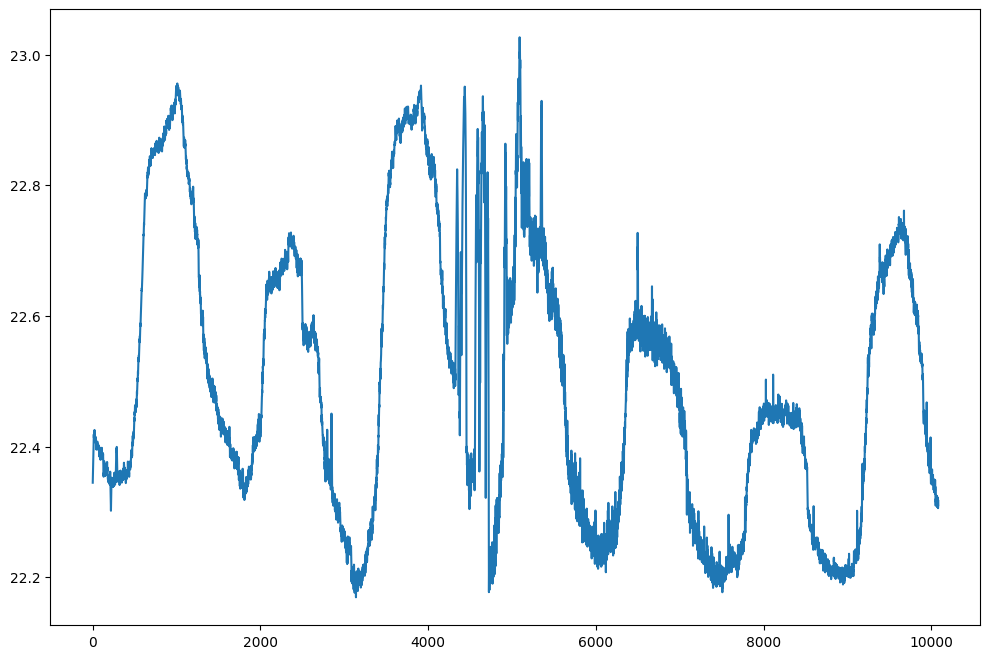

In [63]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')

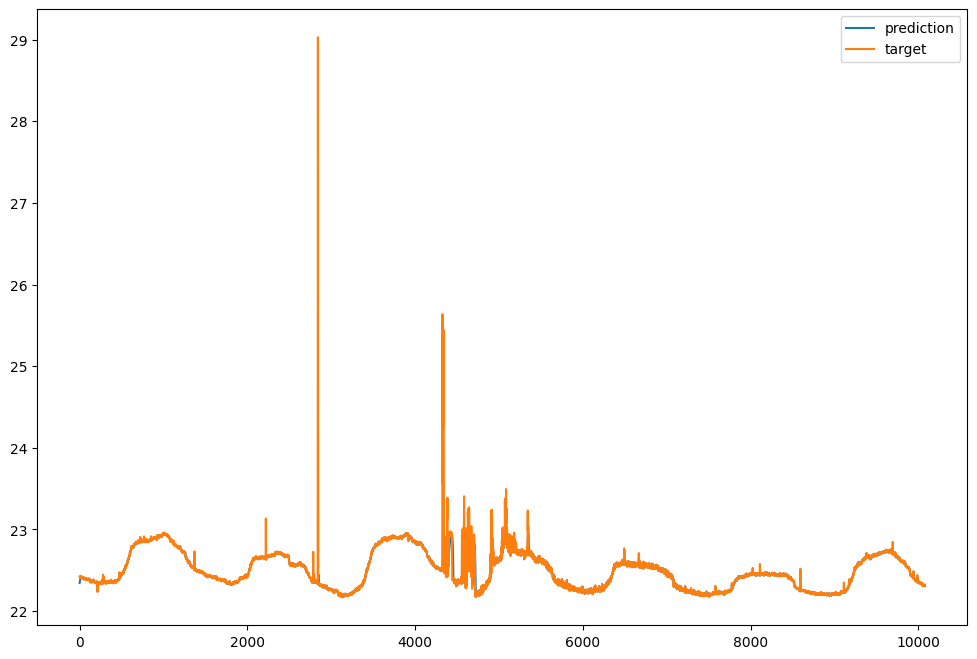

In [58]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [59]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.09649836272001266 %


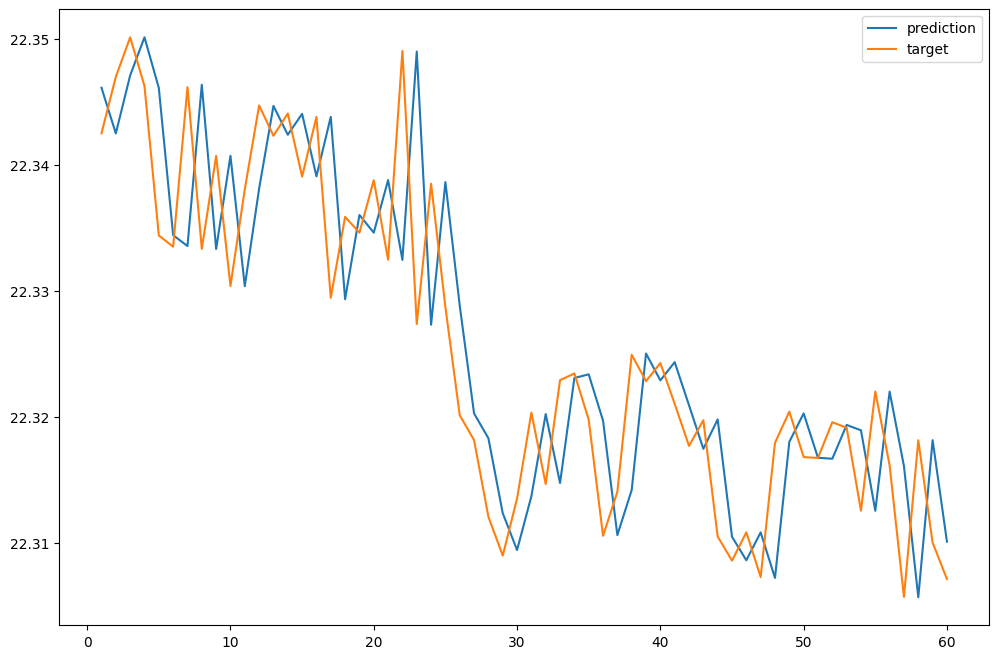

In [60]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

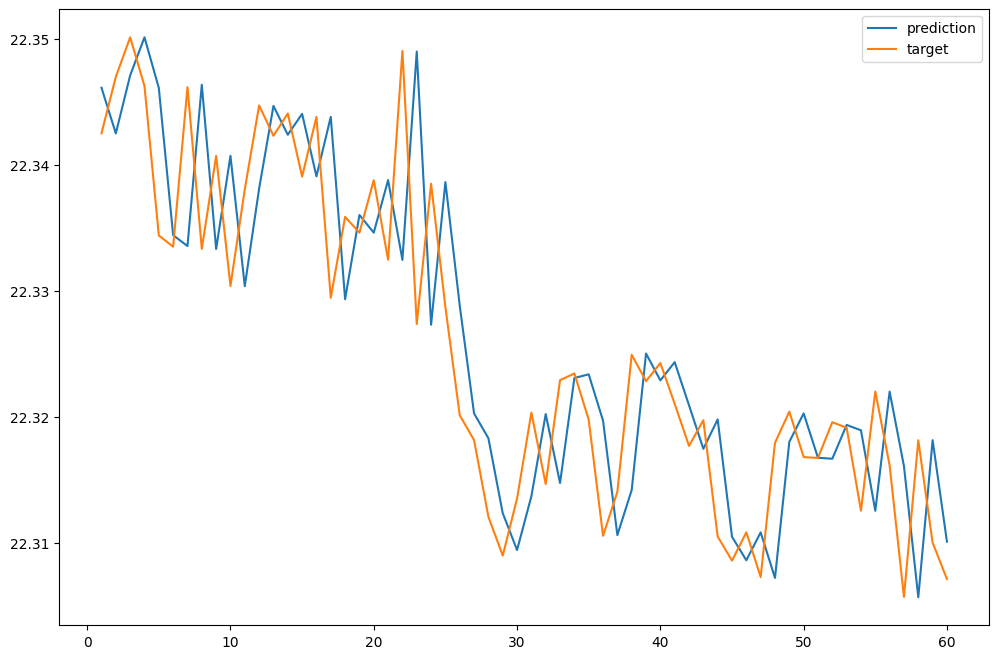

In [61]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [62]:
np.mean(time_list)

0.7578138489571828

1step과 비교했을때level을 맞추면서 sliding을 하게됨